# Customer Churn Prediction using Machine Learning

**Full notebook**: data loading → EDA → preprocessing → feature engineering → model training (Logistic Regression, Decision Tree, Random Forest, SVM) → evaluation & visualizations.

> **Note:** Update the dataset path in the first code cell if your CSV is located elsewhere (default: `data/Telco-Customer-Churn.csv`).

In [49]:
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, precision_score, recall_score, f1_score, RocCurveDisplay

print('Libraries loaded')

Libraries loaded


In [50]:
# Load dataset (update path if needed)
data_path = './../data/Telco-Customer-Churn.csv'  # <-- change this if your file is elsewhere
if not os.path.exists(data_path):
    print(f"Warning: {data_path} not found. Please place the Telco CSV at this path or update the variable.")
else:
    df = pd.read_csv(data_path)
    print('Data loaded. Shape:', df.shape)
    display(df.head())

Data loaded. Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1) Quick Data Inspection

Run the cell below to inspect types, nulls, and a basic summary.

In [51]:
# Basic info
try:
    display(df.info())
    display(df.isnull().sum())
    display(df.describe(include='all').T.head(30))
except NameError:
    print('Dataframe `df` not defined. Please run the data loading cell.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Data Cleaning & Preprocessing
- Convert total charges to numeric if needed
- Drop customerID
- Encode target variable `Churn`

In [52]:
# Data cleaning
if 'df' in globals():
    data = df.copy()
    # Drop customerID if present
    if 'customerID' in data.columns:
        data.drop('customerID', axis=1, inplace=True)
    
    # Convert TotalCharges to numeric if present (some rows may be blank)
    if 'TotalCharges' in data.columns:
        data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    
    # Show nulls introduced by conversion
    print('Nulls per column after conversion:')
    display(data.isnull().sum())
    
    # Drop rows with missing values (simple approach)
    data.dropna(inplace=True)
    print('Shape after dropping NA:', data.shape)
    
    # Map target
    if 'Churn' in data.columns:
        data['Churn'] = data['Churn'].map({'Yes':1, 'No':0})
    
    display(data.head())

Nulls per column after conversion:


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Shape after dropping NA: (7032, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## 3) Exploratory Data Analysis (EDA)
- Distribution of target
- Numeric feature distributions
- Correlation heatmap

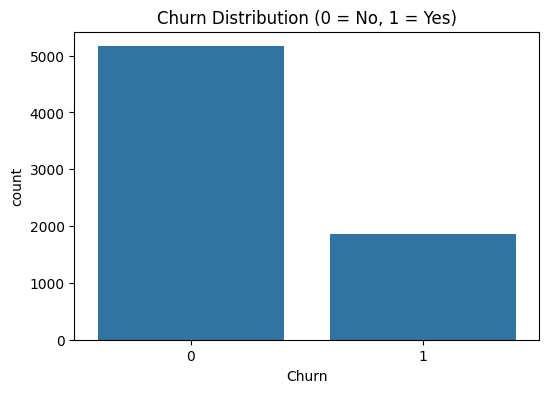


Churn Rate:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64



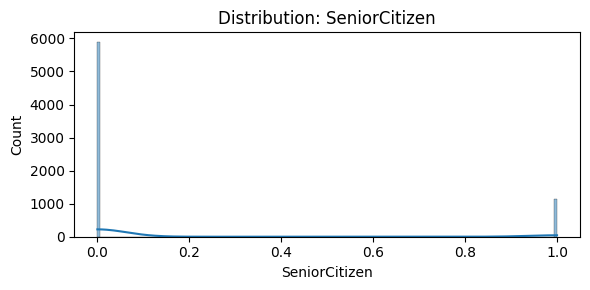

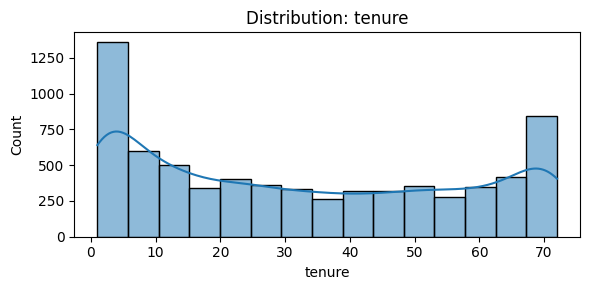

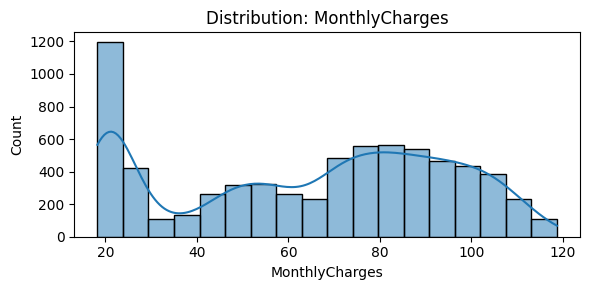

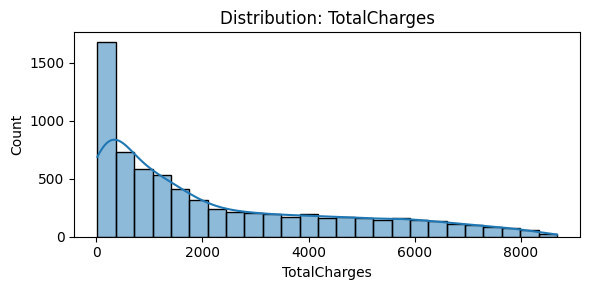

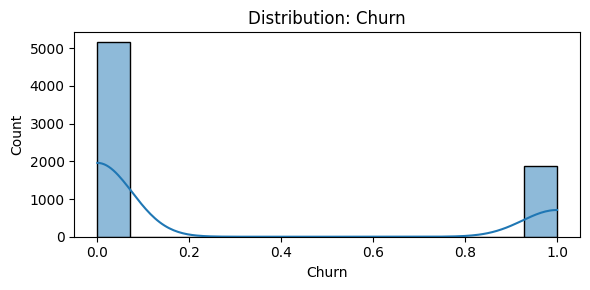

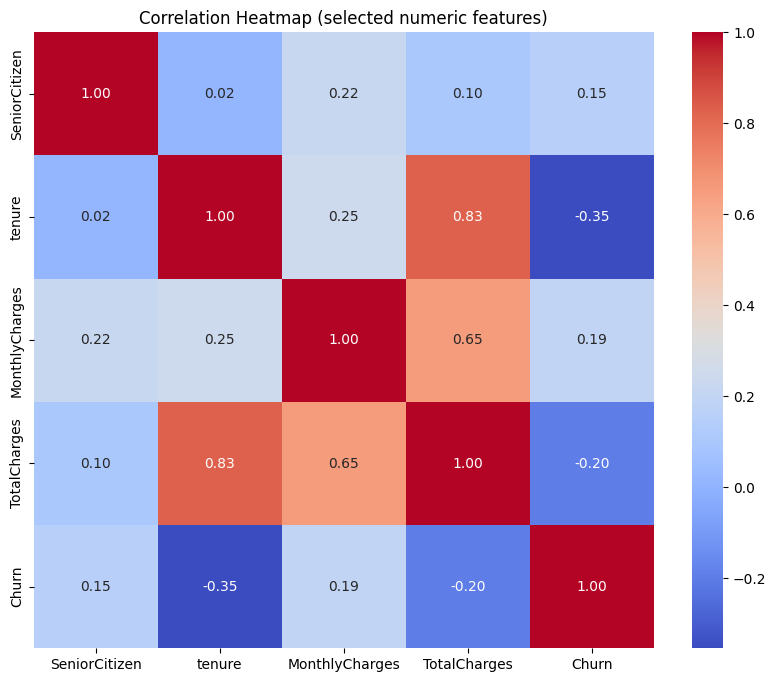

In [53]:
# EDA plots
if 'data' in globals():
    plt.figure(figsize=(6,4))
    sns.countplot(x='Churn', data=data)
    plt.title('Churn Distribution (0 = No, 1 = Yes)')
    plt.show()

    print("\nChurn Rate:")
    print(df["Churn"].value_counts(normalize=True))
    print()

    # Numeric feature distribution examples
    num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
    num_cols = [c for c in num_cols][:6]
    for col in num_cols:
        plt.figure(figsize=(6,3))
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution: {col}')
        plt.tight_layout()
        plt.show()

    # Correlation heatmap (sampled to keep it readable)
    plt.figure(figsize=(10,8))
    sns.heatmap(data[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap (selected numeric features)')
    plt.show()
else:
    print('Run previous cells to load and clean data')

## 4) Feature Engineering
- One-hot encode categorical variables or label-encode them
- Scale numeric features for algorithms like SVM


In [54]:
# Feature engineering & encoding
if 'data' in globals():
    df_fe = data.copy()
    
    # Separate categorical and numerical
    cat_cols = df_fe.select_dtypes(include=['object']).columns.tolist()
    num_cols = df_fe.select_dtypes(include=['number']).columns.tolist()
    num_cols = [c for c in num_cols if c != 'Churn']
    
    print('Categorical columns:', cat_cols)
    print('Numeric columns:', num_cols)
    
    # Simple encoding: for low-cardinality categoricals use one-hot, for binary/object use LabelEncoder
    # We'll use get_dummies for simplicity (drop_first to avoid multicollinearity)
    df_fe = pd.get_dummies(df_fe, columns=cat_cols, drop_first=True)
    print('Shape after get_dummies:', df_fe.shape)
    
    # Feature matrix and target
    X = df_fe.drop('Churn', axis=1)
    y = df_fe['Churn']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    print('Train/Test shapes:', X_train.shape, X_test.shape)
else:
    print('Run earlier cells to prepare data')

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Shape after get_dummies: (7032, 31)
Train/Test shapes: (5625, 30) (1407, 30)


### Scaling
We scale numeric features for SVM — using StandardScaler. For tree-based models scaling is not required but won't hurt when included in pipeline.

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

if 'X_train' in globals():
    # Identify numeric columns for scaling (intersection with original num_cols)
    numeric_features = [c for c in X_train.columns if any(ch.isdigit() or ch.isalpha() for ch in c) and c in X_train.columns]
    # Simpler: scale all features (after get_dummies everything is numeric)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print('Data scaled.')
else:
    print('Prepare features first')

Data scaled.


## 5) Model Training & Evaluation
We train four models and compare accuracy, classification report, confusion matrix, and ROC AUC where applicable.


Logistic Regression -> Accuracy: 0.80312722, ROC AUC: 0.83629142
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



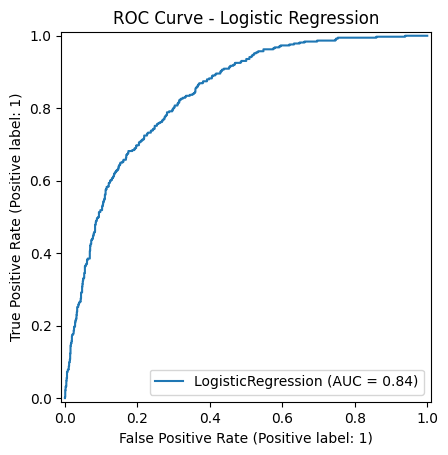


Decision Tree -> Accuracy: 0.71855011, ROC AUC: 0.63663800
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1033
           1       0.47      0.46      0.47       374

    accuracy                           0.72      1407
   macro avg       0.64      0.64      0.64      1407
weighted avg       0.72      0.72      0.72      1407



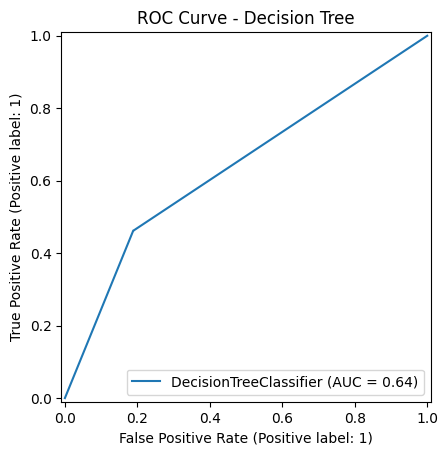


Random Forest -> Accuracy: 0.78749112, ROC AUC: 0.81707270
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



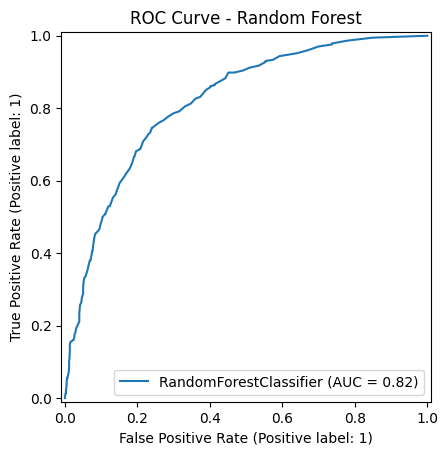


SVM -> Accuracy: 0.78678038, ROC AUC: 0.79085241
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



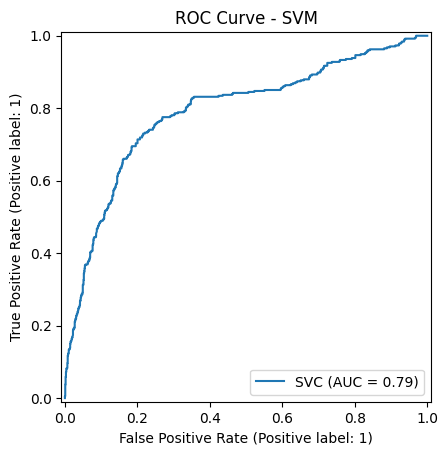


Naive Bayes -> Accuracy: 0.64392324, ROC AUC: 0.81050080
              precision    recall  f1-score   support

           0       0.92      0.56      0.70      1033
           1       0.42      0.86      0.56       374

    accuracy                           0.64      1407
   macro avg       0.67      0.71      0.63      1407
weighted avg       0.79      0.64      0.66      1407



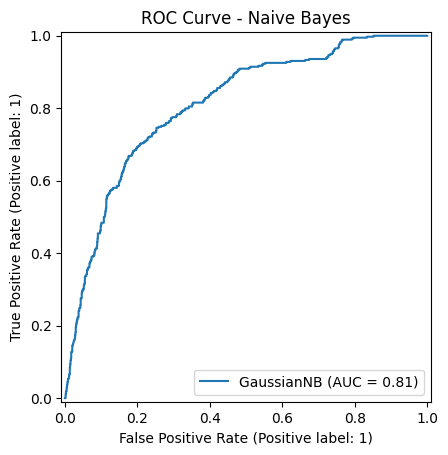

In [56]:
# Train models
if 'X_train' in globals():
    # Use scaled for SVM, use unscaled for tree but it's fine to use scaled variants for consistency
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Naive Bayes': GaussianNB()
    }

    trained = {}
    results = {}
    for name, model in models.items():
        if name == 'SVM':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:,1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # some models have predict_proba
            try:
                y_prob = model.predict_proba(X_test)[:,1]
            except Exception:
                y_prob = None

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1-score': f1, 'roc-auc': auc, 'report': report, 'confusion_matrix': cm, 'roc_auc': roc_auc}
        trained[name] = model

        print()
        print(f"{name} -> Accuracy: {acc:.8f}", end='')
        if roc_auc is not None:
            print(f", ROC AUC: {roc_auc:.8f}")
            print(classification_report(y_test, y_pred))
        else:
            print('')

        if name == 'SVM':
          RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
        else:
          RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f"ROC Curve - {name}")
        plt.show()

else:
    print('Prepare features first')

In [57]:
import os

# Define path to save in the root-level 'outputs' folder
output_dir = os.path.join(os.path.dirname(os.getcwd()), "outputs")
os.makedirs(output_dir, exist_ok=True)

### Confusion Matrices & ROC Curves

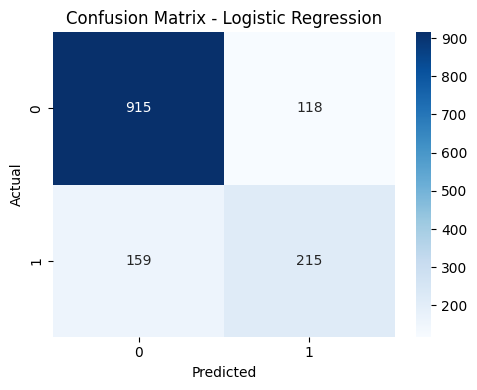

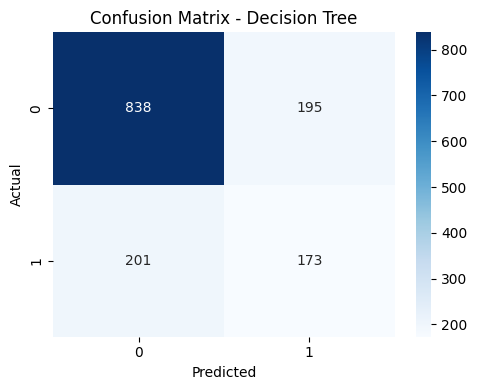

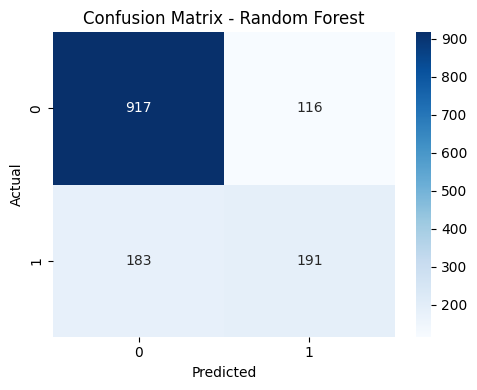

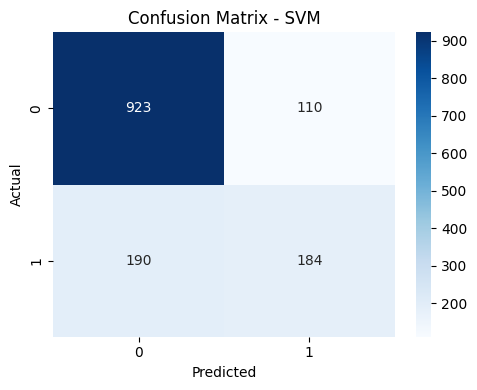

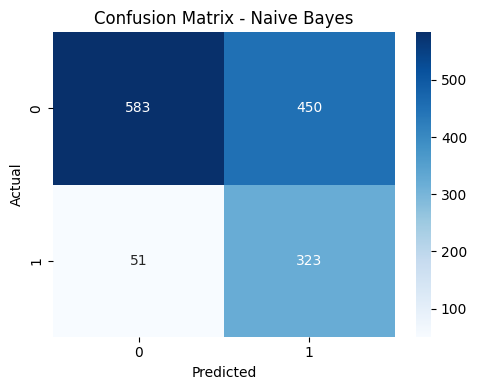

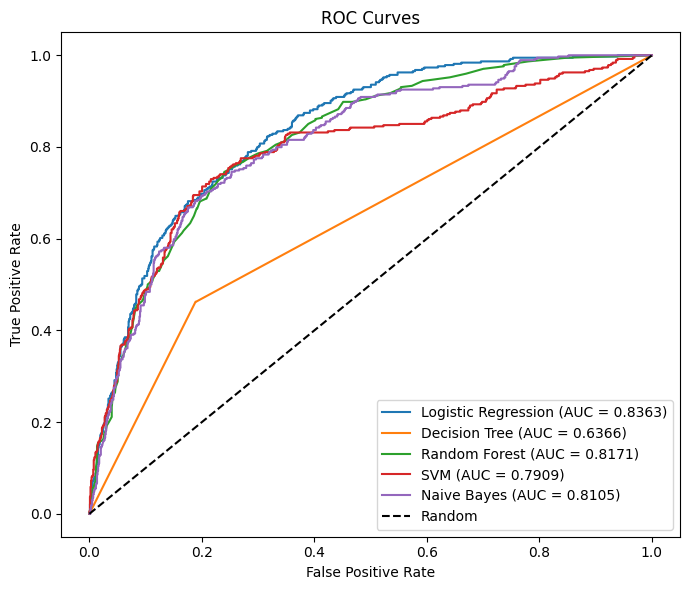

In [58]:
# Plot confusion matrices and ROC curves, save outputs
if 'results' in globals():
    for name, res in results.items():
        cm = res['confusion_matrix']
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{output_dir}/confusion_matrix_{name.replace(" ","_")}.png')
        plt.close()


    # ROC curves
    plt.figure(figsize=(7,6))
    for name, model in trained.items():
        try:
            if name == 'SVM':
                y_prob = model.predict_proba(X_test_scaled)[:,1]
            else:
                y_prob = model.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")
        except Exception as e:
            print(f"Skipping ROC for {name}: {e}")
    plt.plot([0,1],[0,1],'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_dir}/roc_curves.png')
    plt.show()
else:
    print('Run model training cell first')

## 6) Results Summary & Next Steps
- Review metrics above for model selection
- Consider hyperparameter tuning (GridSearchCV) and class imbalance handling (SMOTE, class_weight)

### Save a compact summary to CSV

In [59]:
if 'results' in globals():
    summary = []
    for name, r in results.items():
        summary.append({
            'Model': name,
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1-score': r['f1-score'],
            'ROC-AUC': r['roc-auc']
        })

    summary_df = pd.DataFrame(summary).sort_values('Accuracy', ascending=False)
    print("Model Performance Summary Before Hyperparameter Tuning:\n")
    display(summary_df)

    # Save CSV in the root-level outputs directory
    output_path = os.path.join(output_dir, "model_summary.csv")
    summary_df.to_csv(output_path, index=False)

    print(f"Saved {output_path}")
else:
    print("Run model training first to generate results.")

Model Performance Summary Before Hyperparameter Tuning:



,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.803127,0.645646,0.574866,0.608204,0.836291
2,Random Forest,0.787491,0.622150,0.510695,0.560940,0.817073
3,SVM,0.786780,0.625850,0.491979,0.550898,0.790852
1,Decision Tree,0.718550,0.470109,0.462567,0.466307,0.636638
4,Naive Bayes,0.643923,0.417853,0.863636,0.563208,0.810501


Saved /Users/satyamvats/Desktop/sem3/project/customer-churn-prediction/outputs/model_summary.csv


## 7) Hyperparameter Tuning
- Use GridSearchCV or RandomizedSearchCV for best parameters

In [60]:
# Hyperparameter Tuning (GridSearchCV for All)
from sklearn.model_selection import GridSearchCV
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "lbfgs"]
    },
    "Naive Bayes": {
        # GaussianNB has no hyperparameters affecting accuracy much
        "var_smoothing": [1e-09, 1e-08, 1e-07]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "linear"]
    }
}

best_estimators = {}
results = []

for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(
        model,
        param_grids[name],
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    if name == 'SVM':
      grid.fit(X_train_scaled, y_train)
    else:
      grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Best CV ROC-AUC: {grid.best_score_:.8f}")


🔍 Tuning Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Best CV ROC-AUC: 0.84666572

🔍 Tuning Decision Tree...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
Best CV ROC-AUC: 0.82761144

🔍 Tuning Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best CV ROC-AUC: 0.84538673

🔍 Tuning SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV ROC-AUC: 0.83689474

🔍 Tuning Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params for Naive Bayes: {'var_smoothing': 1e-08}
Best CV ROC-AUC: 0.82268041


# 8) Evaluate tuned models
- Re-evaluate models with best parameters


Logistic Regression -> Accuracy: 0.80312722, ROC AUC: 0.83626036
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



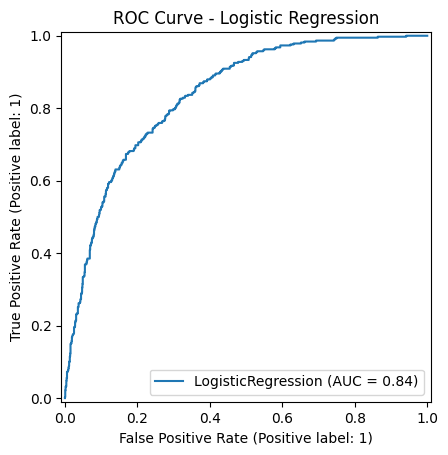


Decision Tree -> Accuracy: 0.77540867, ROC AUC: 0.81638031
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
           1       0.60      0.47      0.53       374

    accuracy                           0.78      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.78      0.77      1407



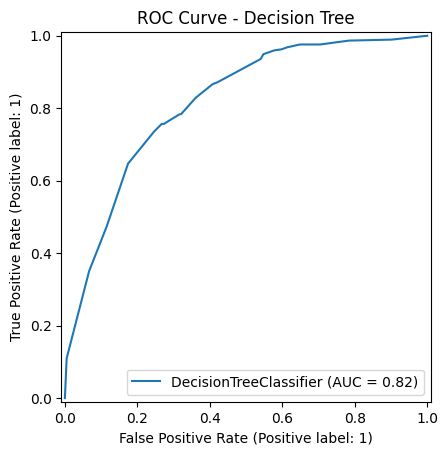


Random Forest -> Accuracy: 0.79530917, ROC AUC: 0.83692946
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1033
           1       0.68      0.44      0.53       374

    accuracy                           0.80      1407
   macro avg       0.75      0.68      0.70      1407
weighted avg       0.78      0.80      0.78      1407



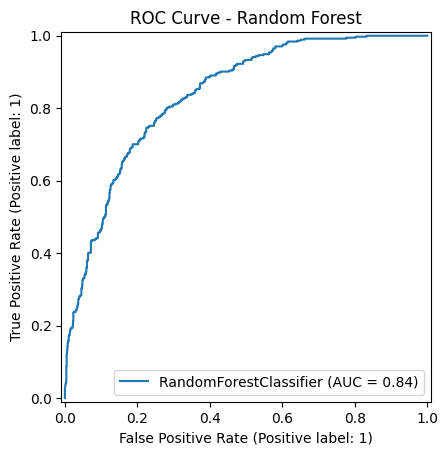


SVM -> Accuracy: 0.79886283, ROC AUC: 0.82731492
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



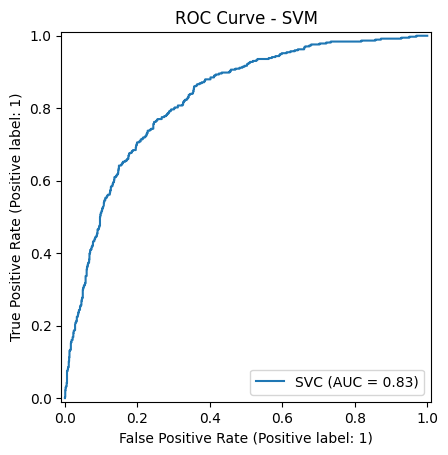


Naive Bayes -> Accuracy: 0.64960910, ROC AUC: 0.81263363
              precision    recall  f1-score   support

           0       0.92      0.57      0.71      1033
           1       0.42      0.87      0.57       374

    accuracy                           0.65      1407
   macro avg       0.67      0.72      0.64      1407
weighted avg       0.79      0.65      0.67      1407



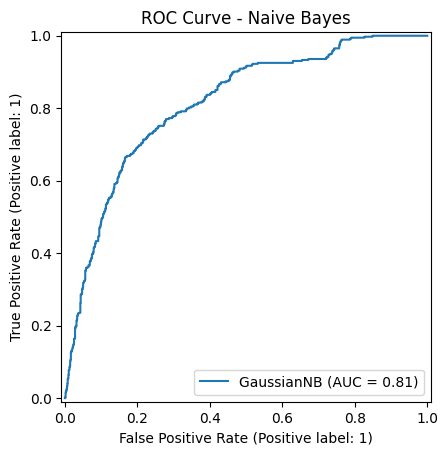

In [61]:
trained_tuned = {}
results_tuned = {}
for name, model in best_estimators.items():
  if name == 'SVM':
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
  else:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_prob)
  report = classification_report(y_test, y_pred, output_dict=True)
  cm = confusion_matrix(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

  results_tuned[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1-score': f1, 'roc-auc': auc, 'report': report, 'confusion_matrix': cm, 'roc_auc': roc_auc}
  trained_tuned[name] = model

  print()
  print(f"{name} -> Accuracy: {acc:.8f}", end='')
  if roc_auc is not None:
    print(f", ROC AUC: {roc_auc:.8f}")
    print(classification_report(y_test, y_pred))
  else:
    print('')

  if name == 'SVM':
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
  else:
    RocCurveDisplay.from_estimator(model, X_test, y_test)
  plt.title(f"ROC Curve - {name}")
  plt.show()


# 9) Confusion Matrices & ROC Curves for Tuned Models

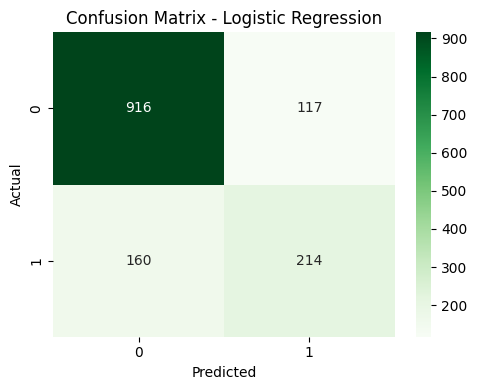

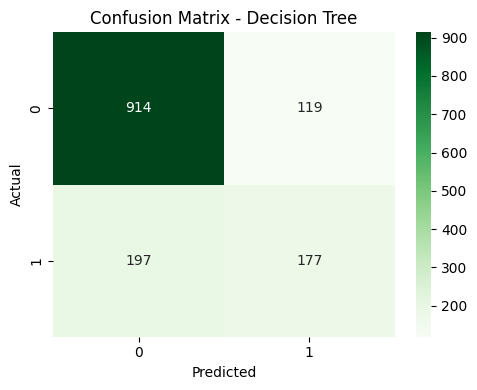

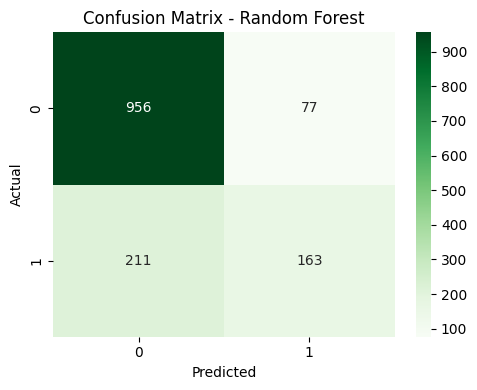

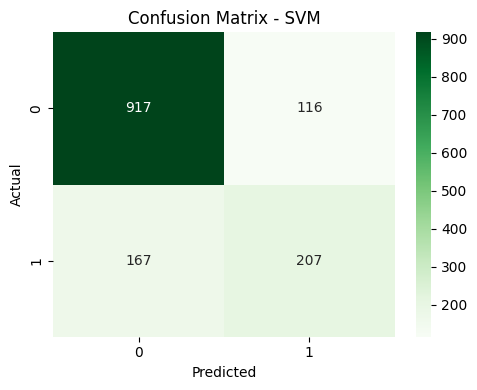

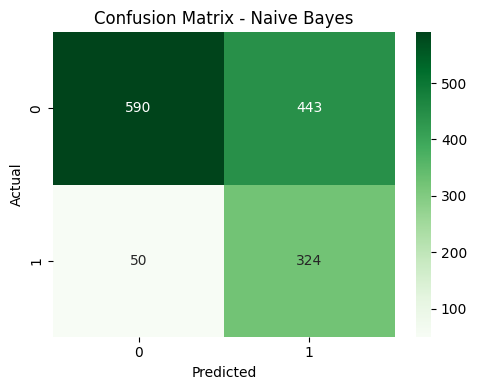

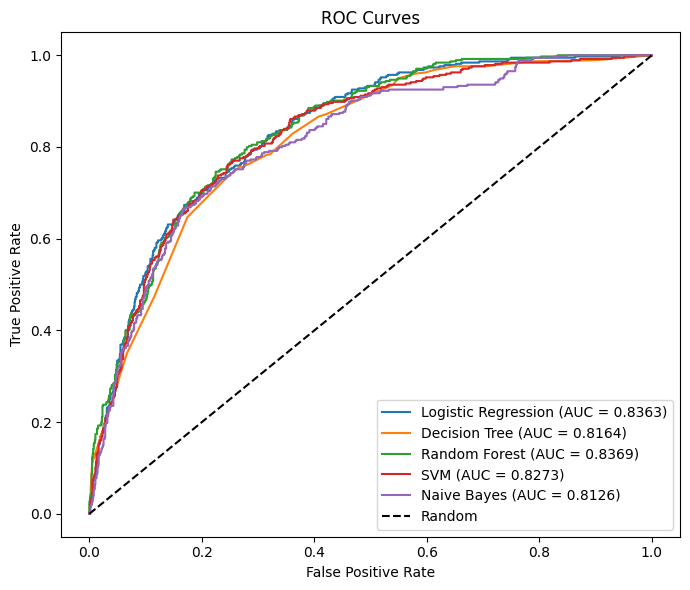

In [62]:
# Plot confusion matrices and ROC curves, save outputs
if 'results_tuned' in globals():
    for name, res in results_tuned.items():
        cm = res['confusion_matrix']
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/confusion_matrix_after_tunning{name.replace(" ","_")}.png')
        plt.show()
        plt.close()


    # ROC curves
    plt.figure(figsize=(7,6))
    for name, model in trained_tuned.items():
        try:
            if name == 'SVM':
                y_prob = model.predict_proba(X_test_scaled)[:,1]
            else:
                y_prob = model.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")
        except Exception as e:
            print(f"Skipping ROC for {name}: {e}")
    plt.plot([0,1],[0,1],'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{output_dir}/roc_curves_after_tunning.png')
    plt.show()
else:
    print('Run model training cell first')

# 10) Tuning Results Summary & Next Steps

In [63]:
if 'results_tuned' in globals():
    summary_tuned = []
    for name, r in results_tuned.items():
        summary_tuned.append({
            'Model': name,
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1-score': r['f1-score'],
            'ROC-AUC': r['roc-auc']
        })

    summary_tuned_df = pd.DataFrame(summary_tuned).sort_values('Accuracy', ascending=False)
    print("Model Performance Summary After Hyperparameter Tuning:\n")
    display(summary_tuned_df)

    # Save CSV in the root-level outputs directory
    output_path = os.path.join(output_dir, "model_summary_tuned.csv")
    summary_tuned_df.to_csv(output_path, index=False)

    print(f"Saved {output_path}")
else:
    print("Run model training first to generate results.")

Model Performance Summary After Hyperparameter Tuning:



,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.803127,0.646526,0.572193,0.607092,0.836260
3,SVM,0.798863,0.640867,0.553476,0.593974,0.827315
2,Random Forest,0.795309,0.679167,0.435829,0.530945,0.836929
1,Decision Tree,0.775409,0.597973,0.473262,0.528358,0.816380
4,Naive Bayes,0.649609,0.422425,0.866310,0.567923,0.812634


Saved /Users/satyamvats/Desktop/sem3/project/customer-churn-prediction/outputs/model_summary_tuned.csv


# 11) Compare Accuracy Before and After Tuning


🔍 Accuracy & Error Rate Comparison (Before vs After Tuning):


,Model,Accuracy_Before,Accuracy_After,Error_Before,Error_After
0,Logistic Regression,0.803127,0.803127,0.196873,0.196873
1,Random Forest,0.787491,0.795309,0.212509,0.204691
2,SVM,0.786780,0.798863,0.213220,0.201137
3,Decision Tree,0.718550,0.775409,0.281450,0.224591
4,Naive Bayes,0.643923,0.649609,0.356077,0.350391


📁 Saved comparison summary to: /Users/satyamvats/Desktop/sem3/project/customer-churn-prediction/outputs/model_comparison_before_after_tuning.csv


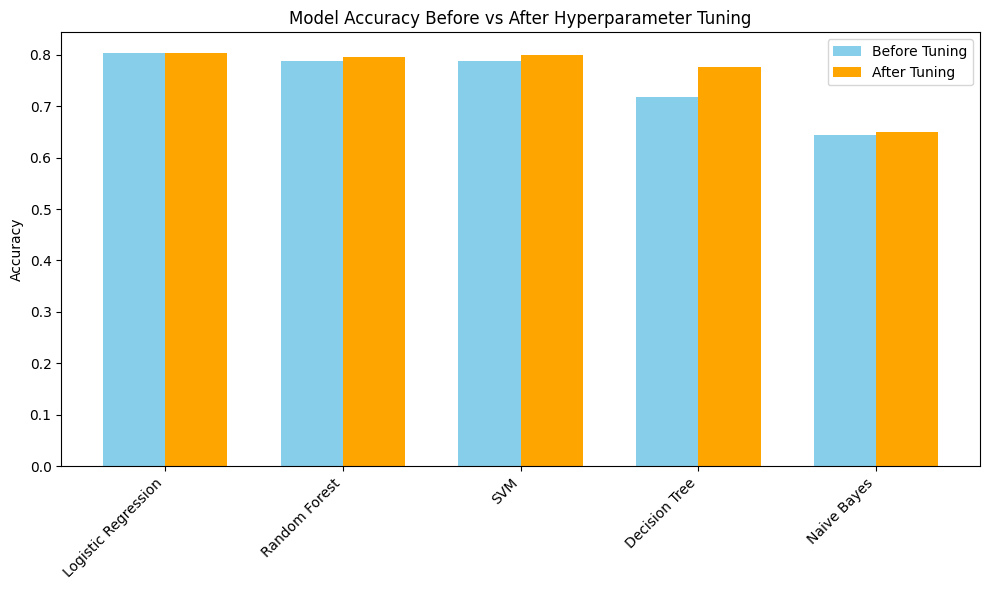

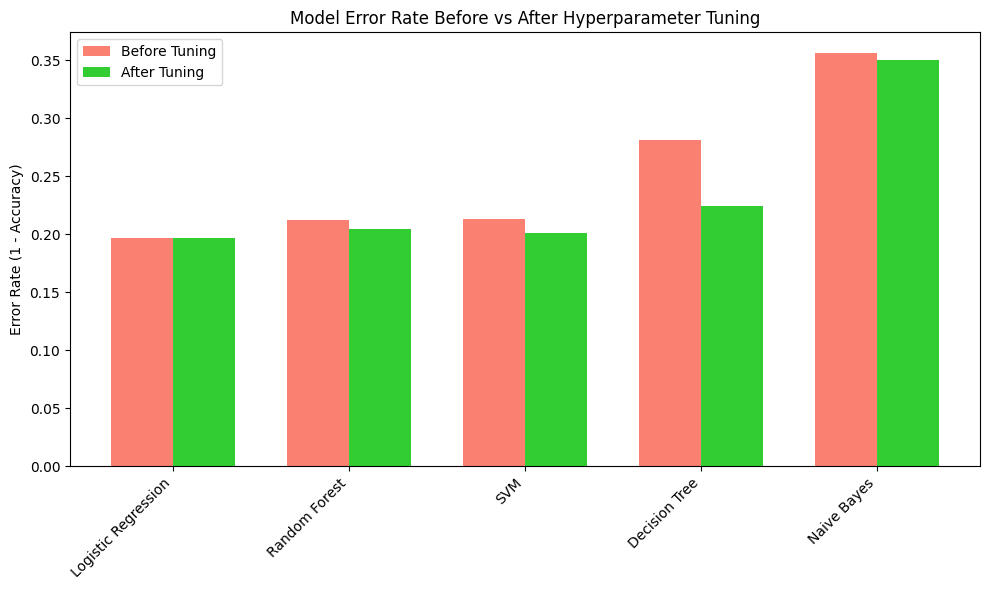

In [64]:
#  Compare Accuracy & Error Rate Before vs After Hyperparameter Tuning

if 'summary_df' in globals() and 'summary_tuned_df' in globals():
    # Merge results on Model name
    comparison_df = pd.merge(
        summary_df[['Model', 'Accuracy']],
        summary_tuned_df[['Model', 'Accuracy']],
        on='Model',
        suffixes=('_Before', '_After')
    )

    # Calculate error rates
    comparison_df['Error_Before'] = 1 - comparison_df['Accuracy_Before']
    comparison_df['Error_After'] = 1 - comparison_df['Accuracy_After']

    print("\n🔍 Accuracy & Error Rate Comparison (Before vs After Tuning):")
    display(comparison_df)

    # Save comparison summary
    comp_path = os.path.join(output_dir, "model_comparison_before_after_tuning.csv")
    comparison_df.to_csv(comp_path, index=False)
    print(f"📁 Saved comparison summary to: {comp_path}")

    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(len(comparison_df['Model']))

    plt.bar(x - bar_width/2, comparison_df['Accuracy_Before'], bar_width, label='Before Tuning', color='skyblue')
    plt.bar(x + bar_width/2, comparison_df['Accuracy_After'], bar_width, label='After Tuning', color='orange')

    plt.xticks(x, comparison_df['Model'], rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Before vs After Hyperparameter Tuning')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot error rate comparison
    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, comparison_df['Error_Before'], bar_width, label='Before Tuning', color='salmon')
    plt.bar(x + bar_width/2, comparison_df['Error_After'], bar_width, label='After Tuning', color='limegreen')

    plt.xticks(x, comparison_df['Model'], rotation=45, ha='right')
    plt.ylabel('Error Rate (1 - Accuracy)')
    plt.title('Model Error Rate Before vs After Hyperparameter Tuning')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Please ensure both summary_df (before tuning) and summary_tuned_df (after tuning) are defined.")

----

### Notes
- This notebook aims to be reproducible; ensure the dataset CSV path is correct.
- For a production-ready pipeline, separate scripts, more robust preprocessing, cross-validation, and logging are recommended.
